# Fast and Fourier Torchform Introduction

Introductory notebook for frequency analysis and basic operations using pytorch as backend.

`contact: mario.coutinominguez@tno.nl`

## Imports

### Computation backend

Our computational backend for this session will be `pytorch` aka _torch_. Why? The faster that you get use to working on torch as a backend the easier it will be to write code for optimization/neural networks for general applications. Also, changing between `numpy` and `pytorch` is a matter of changing the backend (the first part of the method -before the punt) as most of the calls of `numpy` are included in the backbone of `pytorch`. Finally, putting things into the gpu does not take any effort at all :)

In [1]:
import torch

## Ploting backend

We will be sticking to the classic `matplotlib`. There are other backends that could be used, e.g., `seaborn`, `plotly`, etc. However, bear with me and keep it simply. We are not aiming to make beautiful plots (at least not yet). Warning: `matplotlib` is terrible for interactive ploting. However, I would argue that we can always defer that to `MATLAB`. We will do so later.

In [2]:
import matplotlib.pylab as plt

## Chirp Definition

We first start by defining a [chirp](https://en.wikipedia.org/wiki/Chirp) function

$$
s(t) = \begin{cases} 
    e^{j\pi\big(\frac{B}{t_p} t^2 - Bt\big)} & 0 \leq t \leq t_p \\
    0 & \text{otw}
\end{cases}
$$

_Note_: Here, we use the typical "base band" [complex envelop](https://www.gaussianwaves.com/2017/10/complex-baseband-equivalent-models/) representation of a signal. Remember that all signal that are transmitted are _real_. However, to ease the mathematical analysis, we tend to use a complex representation of them.

In [6]:
def up_chirp(bandwidth : float, chirp_duration : float, sampling_frequency : float):
    '''Basic Up-Chirp: '''
    t = torch.arange(0,chirp_duration-1/sampling_frequency,1/sampling_frequency)
    return t,torch.exp(1j*torch.pi*(bandwidth/chirp_duration*t**2 - bandwidth*t))

Let see how our function looks in time...

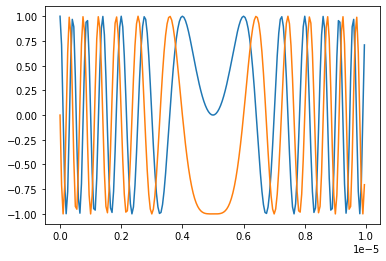

In [8]:
t,signal = up_chirp(bandwidth=5E6, chirp_duration=10E-6, sampling_frequency=4*5E6)

plt.plot(t,torch.real(signal))
plt.plot(t,torch.imag(signal))
plt.show()

## Looking in it Fourier Spectrum
To see how it looks in frequency, we will make use of the [Fourier transform](https://en.wikipedia.org/wiki/Fourier_transform) 
$$
X(f) = \int_{-\infty}^{\infty}x(t)e^{-j2\pi f t}dt
$$
to quickly see which frequency components are present in the signal.

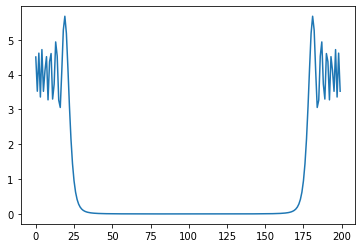

In [52]:
fft_signal = torch.fft.fft(
    input=signal,
    n=len(signal),
    dim=0,
    norm="ortho"
)

plt.plot(torch.abs(fft_signal)**2)
plt.show()

* What is the correct x-axis? Which dimension should/can it be?

* Also, what does `norm=ortho` does? What happen if you use a different value in this argument?

* What is the effect of changing of number of fft points `n`? What does the function internally do? 

Hint: _check the pytorch API help_ [link](https://pytorch.org/docs/stable/generated/torch.fft.fft.html#torch.fft.fft)

In [19]:
# give it a try

### Finding its bandwidth
Using the power spectrum (PSD) we can find the bandwidth of our signal. 

If you struggle finding the right x-axis, look at the help of `torch.fft.fftfreq`. Here, we use it to automatically get the _normalized frequencies_.

As these frequencies are _normalized_, we need to remember the [_Nyquist theorem_](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem).  If you don't know it, give a quick look at the link.

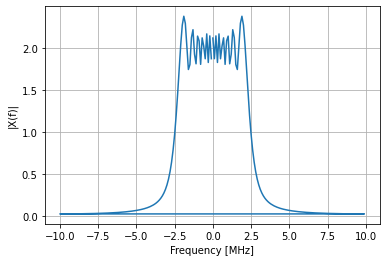

In [63]:
freq_grid = torch.fft.fftfreq(len(signal))

sampling_frequency = 4*5E6
plt.plot(freq_grid * sampling_frequency * 1E-6,torch.abs(fft_signal))
plt.xlabel('Frequency [MHz]')
plt.ylabel(r'|X(f)|')
plt.grid()
plt.show()

From the plot, it is seen that our bandwith is indeed the `bandwidth=5E6` as we defined in the `up_chirp` function.

Notice that there is a weird line below and that the value at `0.0` seems to be missing. Though to operate with the data/frequencies it doesnt matter much, for plotting sometimes it is nice to have them display ordered in the array. For that, we can use the `fftshit` and `ifftshift` functions.

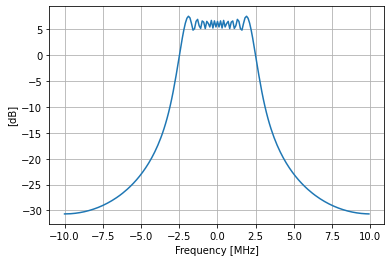

In [38]:
freq_grid_ordered = torch.fft.fftshift(freq_grid)
fft_signal_ordered = torch.fft.fftshift(fft_signal)

psd_db = 20*torch.log10(torch.abs(fft_signal_ordered))

plt.plot(freq_grid_ordered * sampling_frequency * 1E-6, psd_db)
plt.grid()
plt.ylabel('[dB]')
plt.xlabel('Frequency [MHz]')
plt.show()

Here, we have plot the results in [dBs](https://www.radartutorial.eu/18.explanations/ex15.en.html).

### Checking the signal and spectrum energy

Now, we come back to the the reason of using `norm=ortho` and look at the energy of the fft of the signal and the signal itself.

For reference, see the [Parseval's theorem](https://en.wikipedia.org/wiki/Parseval%27s_theorem)

$$
\int_{-\infty}^{\infty}|x(t)|^2 = \int_{\infty}^{\infty}|X(2\pi f)|^2df
$$

In [45]:
energy_fft = sum(torch.abs(fft_signal)**2)
energy_signal = sum(torch.abs(fft_signal)**2)

print(f'Post-FFT Energy: {energy_fft}')
print(f'Original Signal Energy: {energy_signal}')

Post-FFT Energy: 200.0000457763672
Original Signal Energy: 200.0000457763672


Let us consider a different normalization. For example, the default.

In [48]:
fft_signal_unnormalized = torch.fft.fft(
    input=signal,
    n=len(signal),
    dim=0,
)

energy_unnormalized_fft = sum(torch.abs(fft_signal_unnormalized)**2)
print(f'Post-(unnormalized)FFT Energy: {energy_unnormalized_fft}')
print(f'Missing factor: {energy_unnormalized_fft/energy_signal}')

Post-(unnormalized)FFT Energy: 39999.98828125
Missing factor: 199.99989318847656


Although to guarantee energy preservation ([_orthonormal transfom_](https://en.wikipedia.org/wiki/Orthogonal_matrix)) we need to select the correct parameter or scale the result, the `ifft` function applies the appropriate correction in order to guarantee a proper _inverse operation_.

In [50]:
energy_signal_post_ifft = sum(torch.abs(torch.fft.ifft(fft_signal_unnormalized,len(signal),dim=0))**2)
print(f'Post-IFFT Signal Energy: {energy_signal_post_ifft}')

Post-IFFT Signal Energy: 200.0


Despite this _expected behavior_, it is always better to consider FFT as an _orthonormal transform_ to avoid confusions due to scalings when `fft`s and `ifft`s are stacked.

## Why "the chirp"?

### PSD does not show the _chirping_ behavior

The clasical step (brick/rectangular) spectrum of a chirp -also called linear frequency modulated (LFM) waveform, is directly seen with the `fft`. However, its _chirping_, i.e., instantaneuos frequency changing linearly in time, behavior it is not seen there. For that, we need to analyze the signal using a _time-frequency_ representation. That is, we are making not a one-dimensional signal but an image out of it. This image is what is typically called an [spectogram](https://en.wikipedia.org/wiki/Spectrogram). 

_Note_: We compute this time-frequency representation using the short-time-Fourier-transform (STFT) which share the relation
$$
    \text{spectogram}(t,\omega) = |{\rm STFT}(t,\omega)|^2
$$
though there exists other time-frequency representation of signals as for example the [Wigner distribution function (WDF)](https://en.wikipedia.org/wiki/Wigner_distribution_function) that has a very tight relationship with a time-frequency tool that is used in radar signal processing: [_the ambiguity function_](https://en.wikipedia.org/wiki/Ambiguity_function). We will discuss about it later in this notebook.


We now compute the STFT of the signal, given some _default_ parameters. 

In [72]:
stft_signal = torch.stft(
    input=signal,
    n_fft = len(signal),
    hop_length=len(signal)//4,
    win_length=len(signal),
    window=None
)

After visiting the [API doc](https://pytorch.org/docs/stable/generated/torch.stft.html#torch.stft) Can you tell:
- What are the dimensions of the resulting `stft_signal`? 
- What should be the effects of the different parameters that are explicitly defined in the cell below?
- Should there be any _trade-off_ when selecting these parameters? Are they related to the quality of the results in each domain (time/freq)?

In [73]:
# check your intuitions

We consider now a given selection of parameters and see how the resulting spectogram looks like. After running the cells below, changes the `hop_length` and `win_length` parameter and see what are the results. Also, check out the [Hann window](https://pytorch.org/docs/stable/generated/torch.hann_window.html#torch.hann_window) API and try it out. Later on, we will see more about windows though it is good to see already the effects (if any).

In [108]:
stft_signal = torch.stft(
    input=signal,
    n_fft = len(signal),
    hop_length=10,
    win_length=20,
    window=None,
    normalized=True
)

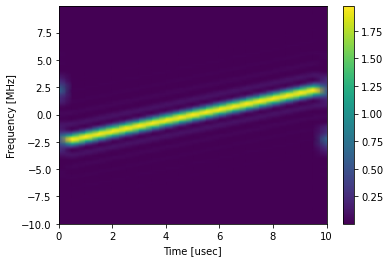

In [112]:
chirp_duration_us = 10
freq_grid_stft_or = torch.fft.fftshift(torch.fft.fftfreq(stft_signal.shape[0]))

time_axis_usec = torch.linspace(0,1,stft_signal.shape[1])*chirp_duration_us
freq_axis_mhz = freq_grid_stft_or * sampling_frequency * 1E-6                   
spectogram = torch.fft.fftshift(torch.abs(stft_signal)**2,axis=0)

plt.pcolormesh(
    time_axis_usec,
    freq_axis_mhz,
    spectogram,
    shading='gouraud')
plt.ylabel('Frequency [MHz]')
plt.xlabel('Time [usec]')
plt.colorbar()
plt.show()

It is now clear that our chirp actually _chirps_, i.e., there is a linear dependency between time and "instantaneous frequency". This relationship is clearly seen from the mathematical expression of the phase/frequency function of the signal. However, we can also see this property through time-frequency analysis tools as the STFT/spectogram. 

Using the spectogram we can observe "instantaneous" changes in frequency behaviour of signals. These change and/or behaviours can be used, for instance, to identify (classify) different type of targets/objects. This is a topic that is nowadays relevant for drones/uav/birds classification. We do this in our group see, [link](https://scholar.google.nl/citations?view_op=view_citation&hl=nl&user=6mL_D78AAAAJ&citation_for_view=6mL_D78AAAAJ:_kc_bZDykSQC).

**Now that you are familiar with the chirp and its frequency analysis, can you also define a _down-chirp_ and a _up-and-down-chirp_?**

_Hint_: For the meantime, create a function for each of them. Once you are done, check your implementation looking at their spectograms!

In [114]:
# your something

**Can you try to reproduce the above analysis for the so-called Hyperbolic Frequency Modulated Waveform?**

You can consult equations (10)-(11) from this paper: [link](https://ecs.syr.edu/faculty/sarkar/pdf/2006_Wiley_MOTL_48_06_1174.pdf).

_Hint:_ Before reading the whole paper and getting the conclusions and differences with respect the LFM, try to do it by looking only at the equations and spectograms!

In [115]:
# your other something

After having played with the HFM waveform, you can already suppose that people has been thinking for years about different frequency modulation schemes. Among them we have the:
- Non-linear frequency modulation
    - Analytical descriptions, e.g., hyperbolic, logarithmic, etc.
    - Computed by the stationary phase principle: [link](https://apps.dtic.mil/sti/pdfs/AD0867198.pdf)
    - Generalized Sinusoidal Frequency Modulation: [link](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=6489140&casa_token=mAsEwrbFbBoAAAAA:Uevt8qBXqov936meNA2yEkJZVgeH6_GRPwSPEtvkMeny_4F9Gn3wvDdGUlJ_0zUg22mw7IS3YA&tag=1)
    - ... 
- Random frequency modulation
    - (Super) Gaussian frequency modulation: [link](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9764296)
    - Optimization procedures

We will not be talking about all of them, but it is always healthy to give them a quick look. Though before doing so, let's argue why the LFM (chirp) waveform is _good_; _so good_ that it is basically an standard in radar. Here, we won't be arguing about why "it is good" in hardware terms (it is "relatively" simple to realize in hardware and it is well-known by engineers) but instead, we will be talking about their correlation properties. This is the reason why is so much loved in radar.

## Correlation Properties

Probably, you are already familiar with _correlations_. If not, give a quick look at this [entry](https://en.wikipedia.org/wiki/Correlation).

In simple terms, correlation is an statistical measure that expresses how much two (random) variables are linearly related, e.g.,
$$
    X := \rho Y + R
$$
where $X, Y,R$ are random variables. Here, $\rho\in\mathbb{R}$ will be "correlation" between $X$ and $Y$ (when $R$ and $Y$ are considered uncorrelated/independent variables).

Here, we are not only interested in correlations between random variables but between "modified" versions of our transmitted signal. In radar, in particular, we are interested in how much time-(and frequency-)shifted versions of the transmitted signal correlated among each others. This analysis is carried by means of [_autocorrelations_](https://en.wikipedia.org/wiki/Autocorrelation).

The (time)autocorrelation (ACF) for deterministic signals is typically defined as
$$
    R_{ss}(\tau) = \int_{-\infty}^{\infty}s(t)\overline{s(t-\tau)}dt
$$
where $\overline{(\cdot)}$ denotes complex conjugation. From this expression, we observe that $R_{ss}(\tau)$ measure how "similar" is the delayed version of $s$, by $\tau$, to the orignal transmitted signal $s(t)$. In radar, as we will want to identify different ranges (time-delays) with high accuracy, it is then normal to expect that our systems transmit signals which are very different across time delays, e.g.,
$$
    R_{ss}^{\text{ideal}}(\tau) = \begin{cases}
        E_\infty & \tau = 0 \\
        0 & \text{otw}
    \end{cases}
$$
where $E_\infty$ is the energy of our transmitted signal, i.e., $E:=\int_{-\infty}^{\infty}|s(t)|^2 dt$.

Unfortunately, nature poses its limits and the ideal ACF cannot be achived. That's why we expend time designing waveforms. We are always looking for waveforms with good or particular ACF properties. And turns out that the LFM is "nice". Let see that.

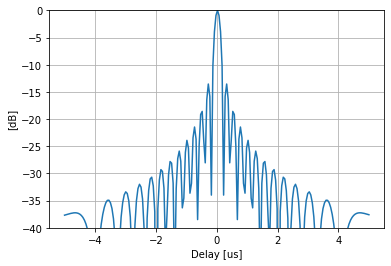

In [207]:
from numpy import correlate, log10, sqrt    # pytorch has no built-in correlation function /
                                            # though it is here imported to show its usage, 
                                            # we compute these quantities with FFTs (next)

acorr = correlate(
    signal,
    signal,
    mode='same')

delay_grid = torch.linspace(-0.5,0.5,len(acorr)) * chirp_duration_us        # similar as with the FFT grid, 
                                                                            # we have a normalized grid that can be scaled.
                                                                            # `correlate' computes the ACF in two directions -thinks why?
                                                                            # also, think what lags are better/worse estimate 
                                                                            # (hint: consider what data is avaialble)

plt.plot(                                                                   # note the ~13dB sidelobes (second set of peaks around 0)
    delay_grid,                                                             # this are characteristic from the LFM -its trademark
    10*log10(abs(acorr/len(signal))**2))
plt.ylim(-40,0)
plt.grid()
plt.xlabel('Delay [us]')
plt.ylabel('[dB]')
plt.show()

From the plot, we observe that the _correlation_ decays rapidly as the lags increases. And this is nice. This means that we can easily distinguish between signals that have large delays among them. Can you think why? _Hint_: go to the spectograms. This is on of the reasons that people like the LFM.

Unfortunately, radar operates with _very very large_ noise levels with respect to our received signals (the signal losses lots of energy while it propagates in the environment and is reflected by the target.) So, in most instances, this autocorrelation levels are not acceptable. Later on, we will discuss briefly how is typically addressed, then, the concept of windowing from before will come back.

_Note: The peak in the region around the `0` lag is called `mainlobe`. The rest of the peaks are referred as `sidelobes`. When a sidelobe is "too large", i.e.g., almost as high as the mainlobe, we refer to it as an `ambiguity`._

Related with autocorrelations, there are other two operations that are very related to it:
- Crosscorrelation  -> instead of correlation of different lags of the same signal, this is done among two different signals
- Convolution       -> as crosscorrelation, but one signal is inverted in time (see second row of figure below)

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/Comparison_convolution_correlation.svg/800px-Comparison_convolution_correlation.svg.png">
<center>

### Autocorrelation: The fast way

The [Wiener-Khinchin theorem](https://en.wikipedia.org/wiki/Wiener%E2%80%93Khinchin_theorem) links the ACF and the power spectral density (PSD) -you do not need to follow the theorem, though is good to know that it exists. This theorem gives the relation
$$
R_{ss}(\tau) = \int_{-\infty}^{\infty}S_{ss}(f)e^{j2\pi f \tau} df
$$
where $S_{ss}(f)$ is the PSD of the signal.

The above relation can read as _the autocorrelation function of the signal $s(t)$ is given by the (inverse)Fourier transform of its power spectral density_.

Given this intuition, the ACF then can be quickly computed by means of fast Fourier transformations:
- $F_s(f) = \text{FFT}[s(t)]$
- $S_{ss}(f) = F_s(f) \overline{F_s(f)} = |F_s(f)|^2$
- $R(\tau) = \text{IFFT}[S_s(f)]$

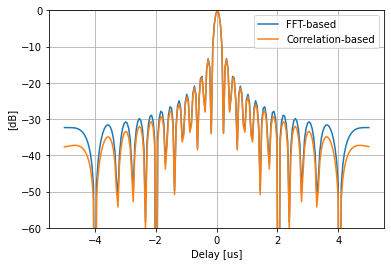

In [141]:
psd_signal = torch.abs(fft_signal)**2
acf = torch.fft.ifft(
    psd_signal,
    len(signal)
)

acf_ordered = torch.fft.fftshift(acf)

# results can slightly differ due to the computation 
# of the ACF for far-away lags (less samples)
# different parameters of `correlate` can also have 
# an small effect

plt.plot(
    delay_grid,
    10*log10(abs(acf_ordered)**2),
    label='FFT-based')
plt.plot(
    delay_grid,
    10*log10(abs(acorr/len(signal))**2),
    label='Correlation-based')
plt.ylim(-60,0)
plt.grid()
plt.xlabel('Delay [us]')
plt.ylabel('[dB]')
plt.legend()
plt.show()

***Can you do the same for the other types of waveforms that you have coded?, e.g., down-chirp, up-down-chirp, HFM?** 

What difference do you see? Are they better? worse? the same?

In [144]:
# do some other your thing

## Delayed Signals, Correlations and Linear algebra

Now, we will construct further intuition for correlation analysis from another angle: one based on a property of the Fourier transform (FT) and _linear algebra_.

First, let us bring the FT property that we will be using:
$$
    \text{Time shifting} \;\;\;s(t-\tau) \rightarrow F_s(f)e^{-j2\pi f \tau}
$$

This property implies that we can "generate" delayed version of our signal by just applying a uniform phase shift across its frequency spectrum. Note that a uniform phase shift can be generated as the entries of the [discrete Fourier transform](https://en.wikipedia.org/wiki/Discrete_Fourier_transform#Definition) (DFT) operator (matrix). 

To see this, lets keep in mind the following image

<center>
<img src="https://www.researchgate.net/publication/281768959/figure/fig1/AS:299140404793360@1448332038655/Schematic-diagram-of-sparse-representation.png">
</center>

Forgetting about the dimensions (and probably my orthographic mistakes), lets consider that $D$ is our DFT matrix. In each column, we can observe (using the DFT definiton) a uniform phase shift across frequency, i.e., rows are frequency and columns is in time (remember that we map a time signal into a frequency signal). 

Then, f we consider that the vector $\alpha$ selects time instances, 
- what are the limitations of this approach to create delays?
- what is the ordering that is present in $\alpha$ is we use an FFT operator for the DFT, e.g., `fft.fft`?

To clarify your ideas, lets see the next example


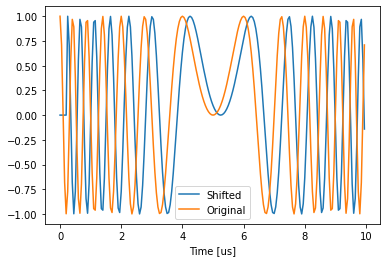

How much has it shifted? And what type of shift was applied?


In [245]:
# lets select a larger extend for our signal
n_fft = 2*len(signal)-1
# generate a one-hot vector with the same lenght as our signal
one_hot = torch.zeros(signal.shape)
# turn on the 5th element
one_hot[5] = torch.sqrt(energy_signal)
# computes its FFT
uniform_phase_shift = torch.fft.fft(
    one_hot,
    n_fft,
    norm="ortho"
)
# apply uniform phase shift to the spectrum of our signal (point-wise -remember the above expression)
fft_signal_long = torch.fft.fft(
    signal,
    n_fft,
    norm="ortho")
shifted_signal_fft = uniform_phase_shift * fft_signal_long
# computes the inverse transform to come back to time
shifted_signal = torch.fft.ifft(
    shifted_signal_fft,
    n_fft,
    norm="ortho"
)
# as we will compare only the first part of the signal we need to compute the scaling ratio for the FFT
ratio = sqrt(n_fft/len(signal))
shifted_signal = ratio*shifted_signal[:len(signal)]

plt.plot(
    t * 1E6,
    torch.real(shifted_signal),
    label="Shifted")
plt.plot(
    t * 1E6,
    torch.real(signal),
    label="Original")
plt.legend()
plt.xlabel('Time [us]')
plt.show()

print('How much has it shifted? And what type of shift was applied?')


Now we compare the above method with other _data manipulative_ method to shift the signal

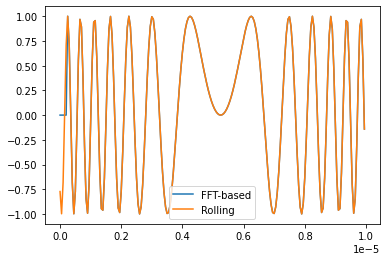

Is almost the same, isn't it? What is the difference? How would you fix the difference?
If we do not extend our FFT with a large signal lenght, i.e., nfft = len(signal), would they be the same? Why?


In [216]:
# pytorch rolling method
rolled_signal = torch.roll(
    signal,
    shifts=5)

plt.plot(
    t,
    torch.real(shifted_signal),
    label="FFT-based")
plt.plot(
    t,
    torch.real(rolled_signal),
    label="Rolling")
plt.legend()
plt.show()

print('Is almost the same, isn\'t it? What is the difference? How would you fix the difference?')
print('If we do not extend our FFT with a large signal lenght, i.e., nfft = len(signal), would they be the same? Why?')

**Can we use the fact that we can zero pad any input to the FFT to create different shifts?**

If so, give it a try and think about what could be the limitations of it.

**Try to play with other ways to delay signals, e.g., with [``torch.nn.functional.interpolate``](https://pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html#torch.nn.functional.interpolate) and [scipy.interpolate.interp1d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html)**

What would the benefit of using these routines? What limitation could they help to mitigate? 

(Extra) Can they handle dilations/contractions?, i.e.,
$$
    \tilde{s}(t) := s(\alpha(t-\tau)),\;\;\alpha\in\mathbb{R}_+
$$

If you think so, give it a try.

In [167]:
# some tries here

**If we are ok with the assumption that FFT-based shifting make**, 
- what would be an advantage of using the FFT-based method instead of rolling?
- and when rolling or a similar method would be useful?
- (extra) what is the equivalent method in `MATLAB` for rolling? 

##### Multiple Delayed Signals

Given what we know now about shifting signals with FFTs, we can put forward a linear-algebra (matrix-vector) model for signals. Let us consider first a continuous time model given by
$$
    r(t) = \sum_{i=1}^{N} \alpha_i s(t-\tau_i)
$$
Here, $r(t)$ will act as a "noiseless" received signal and $N$ are the number of delayed signals that we receive and $\alpha_i\in\mathbb{C}$ is the $ith$ complex amplitude related to the $i$th delayed signal.

Lets check how this data would like.

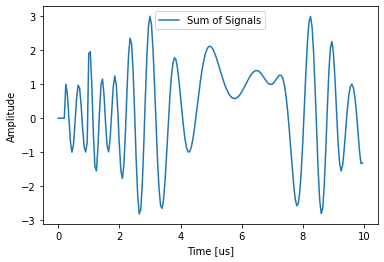

In [220]:
n_zero_pad_left = 0
n_zero_pad_right = 30
padded_signal = torch.nn.functional.pad(signal,(n_zero_pad_left,n_zero_pad_right))
tau_in_samples = (5,20)
alphas = (1,2)
list_of_delayed_signals = [alphas[i] * torch.roll(padded_signal,shifts=tau_samples) for i,tau_samples in enumerate(tau_in_samples)]

r_signal = sum(
    list_of_delayed_signals
)
r_signal = r_signal[:len(signal)]

plt.plot(
    t * 1E6,
    torch.real(r_signal),
    label="Sum of Signals")
plt.legend()
plt.xlabel('Time [us]')
plt.ylabel('Amplitude')
plt.show()

If we assume proper discretization, e.g., $k \cdot t_s$ where $t_s$ is the sampling time, we can write the above model (after sampling) in matrix-vector form
$$
    \begin{align}
    \textbf{r} &= [\textbf{s}(\tau_1),\cdots,\textbf{s}(\tau_N)]\boldsymbol{\alpha} \nonumber \\
               &= \textbf{S}\boldsymbol{\alpha}  
    \end{align}
$$
where $\textbf{s}(\tau_i):=[s(-\tau_i),s(t_s-\tau_i),\cdots]^\top$ and $\boldsymbol{\alpha}=[\alpha_1,\ldots,\alpha_N]^\top$.

Recalling now the shifting property, we can see that each column of the $\textbf{S}$ matrix can be computed using the FFT-based procedure described before, i.e.,
$$
    \textbf{s}(\tau_i) = \text{IFFT}\bigg\{ \text{FFT}\{\textbf{s}\} \odot \text{FFT}\{\textbf{e}_{\tau_i}\}\bigg\}
$$
where $\textbf{s}$ and $\textbf{e}_{\tau_i}$ are the original zero-padded signal and the one-hot vector whose non-zero element correspond to the $\tau_i$ delay (assuming that they delay $\tau$ is in the grid used for the FFT). Here $\odot$ is the point-wise (Hadammard) product.

As a result, the vector $\textbf{r}$ can be equivalently written as
$$
    \textbf{r} = \text{IFFT}\bigg\{\text{diag}(\text{FFT}\{s\})\text{FFT}\{\boldsymbol{\alpha}_\tau\}\bigg\}
$$
where $\text{diag}(\textbf{x})$ denotes a diagonal matrix whose diagonal elements are given by the vector $\textbf{x}$ and we have defined
$$
    \boldsymbol{\alpha}_{\tau}:=\sum_{i}^{N}\alpha_i \textbf{e}_{\tau_i}
$$

Let see how we compute this using FFTs

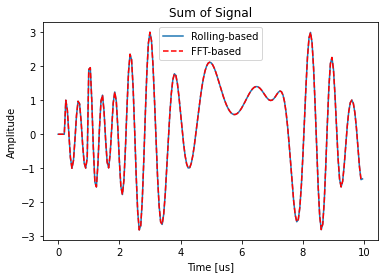

We have managed do get the same signals...


In [247]:
alpha_vec = torch.zeros(signal.shape)
for i in range(len(tau_in_samples)):
    alpha_vec[tau_in_samples[i]] = alphas[i]

r_signal_2 = torch.fft.ifft(
    fft_signal_long *                               # the multiplication of the diagonal matrix with a vector
    torch.fft.fft(alpha_vec,n_fft),                 # can be seen as a point-wise multiplication between vectors   
    norm='ortho'
)
r_signal_2 = r_signal_2[:len(signal)]

plt.plot(
    t * 1E6,
    torch.real(r_signal),
    label="Rolling-based")
plt.plot(
    t * 1E6,
    torch.real(r_signal_2),
    '--r',
    label="FFT-based")
plt.title('Sum of Signal')
plt.legend()
plt.xlabel('Time [us]')
plt.ylabel('Amplitude')
plt.show()
print("We have managed do get the same signals...")

At this point we have created sums of delayed signals -this relates to typical radar scenarios where we receive a sum of reflected signals from the targets at different targets (ranges/distances). Now, we will make use of this to make the _correlation processor_. Basically, we will create delayed versions of a signal and then compute their correlations with respect to another signal. This procedure is typically called [_cross-correlation_](https://en.wikipedia.org/wiki/Cross-correlation).

Consider a (sampled) signal $\textbf{r}$ and a matrix $\mathbf{S}$ whose columns have sampled and delayed versions of a template signal $s(t)$. The correlator processor computes the operation
$$
    \mathbf{y} = \mathbf{S}^{\rm H}\mathbf{r}
$$

If we select uniformly (time-)spaced delayed versions of $s(t)$, the above operation can be computed directly using FFTs, e.g.,

$$
    y = \text{IFFT}\bigg\{ \text{diag}\big(\overline{\text{FFT}\{\mathbf{s}\}}\big) \text{FFT}\{\mathbf{r}\}\bigg\}
$$

_Hint:_ Try linking this statement with the definiton of $\mathbf{s}(\tau)$ from before.

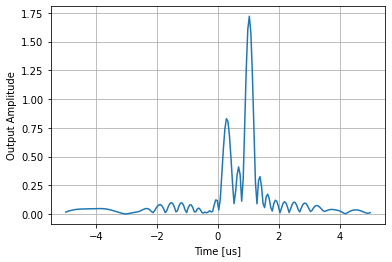

In [264]:
r_fft = torch.fft.fft(
    r_signal,
    len(signal),
    norm="ortho"
)

signal_fft = torch.fft.fft(
    signal,
    len(signal),
    norm="ortho"
)

y = torch.fft.ifft(
    r_fft * torch.conj(signal_fft),
    len(signal)
)

correlator_output = torch.fft.fftshift(abs(y))

plt.plot(
    delay_grid,
    correlator_output)
plt.xlabel('Time [us]')
plt.ylabel('Output Amplitude')
plt.grid()
plt.show()

**What does the peaks mean? What is there relation with the delays we applied?**

Also, if we consider signals whose ACF does not decay quickly, what would be the effect on the correlation processor? And of signalswith high sidelobes?

##### Quick Recap

So far, we have seen:
- the chirp
- frequency and time-frequency analysis -using FFT and STFT
- the properties of the chirp and why people like it
- why correlation analysis is important
- ways to delay signals (digitally, of course)
- and the correlator processor using FFTs

This was a quick introduction to basic signals, frequency analysis and to a fundamental processing tool in radar: the correlation processor. Note that this name is barely used and it is typically only found in certain books and papers. Most of the cases, people will refer to this procedure as applying [_matched filtering_](https://en.wikipedia.org/wiki/Matched_filter). Give it a check and see why it is considered _optimal_.

Check different window function, different signals and try to apply matched filtering to a mixture of them. Add noise to the "received signals" and see the effect on the peaks. Can you try to automatize finding the positions of the peaks in the resulting plots? Change the number of FFTs points and see what is the effect on the results.

Also, watch the [Lecture 5](https://www.ll.mit.edu/outreach/radar-introduction-radar-systems-online-course) of this MIT course and give a look to the Chapter 2 of the book [Radar Signals](https://www.amazon.com/Radar-Signals-Nadav-Levanon/dp/0471473782) (_if you don not have a copy, let me know for a digital version of it_)